In [1]:
import preprocessor

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
FIGURE_SIZE = (12, 6)

In [4]:
import os

TEST_IMG_OUTPUT_PATH = "test_images_output"

if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
test_images = [ 'test_images/{}'.format(filename) for filename in os.listdir("test_images/") ]
test_images.sort()
print(test_images)

['test_images/challenge01.jpg', 'test_images/challenge02.jpg', 'test_images/challenge3.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [5]:
from camera_calibrator import CameraCalibrator, Undistorter



In [6]:
calibrator = CameraCalibrator(9, 6)

calibrator.calibrate()

Searching for calibration images at  camera_cal/*.jpg
20 files found for calibration.
Crunching camera_cal/calibration16.jpg ...
Crunching camera_cal/calibration8.jpg ...
Crunching camera_cal/calibration3.jpg ...
Crunching camera_cal/calibration17.jpg ...
Crunching camera_cal/calibration2.jpg ...
Crunching camera_cal/calibration7.jpg ...
Crunching camera_cal/calibration15.jpg ...
Crunching camera_cal/calibration1.jpg ...
Crunching camera_cal/calibration12.jpg ...
Crunching camera_cal/calibration6.jpg ...
Crunching camera_cal/calibration19.jpg ...
Crunching camera_cal/calibration5.jpg ...
Crunching camera_cal/calibration11.jpg ...
Crunching camera_cal/calibration14.jpg ...
Crunching camera_cal/calibration10.jpg ...
Crunching camera_cal/calibration13.jpg ...
Crunching camera_cal/calibration18.jpg ...
Crunching camera_cal/calibration9.jpg ...
Crunching camera_cal/calibration4.jpg ...
Crunching camera_cal/calibration20.jpg ...
Calibration successful


In [7]:
mtx, dist = calibrator.get_calibration_data()
print(mtx, dist, calibrator.get_shape())
undistorter = Undistorter(mtx, dist, calibrator.get_shape())

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]] (720, 1280)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


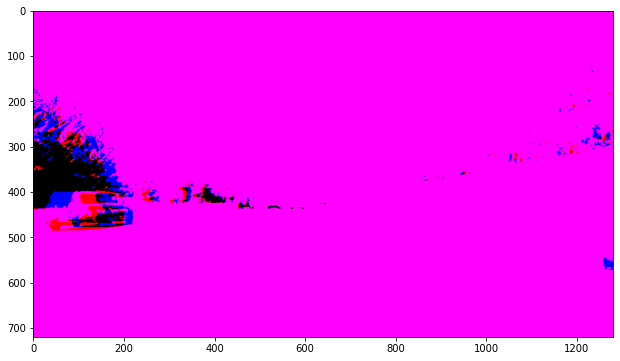

In [8]:
#
#    Calibrator and Undistorter validation
#

img = cv2.imread(test_images[4])
distorted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
undistorted = undistorter.undistort(distorted)

out_shape = [undistorted.shape[0], undistorted.shape[1], 3]
output = np.zeros(out_shape)
output[:,:,0] = cv2.resize(distorted, (out_shape[1], out_shape[0]))//16
output[:,:,2] = undistorted//16
plt.figure(figsize=FIGURE_SIZE)
plt.imshow(output)

In [9]:
def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

def plot_roi_on(img, roi):
    if len(img.shape) == 2:
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        output = img.copy()
    roi_color = (255, 0, 255)
    thickness = 4
    cv2.polylines(output, [roi], True, roi_color, thickness)
    return output
    
def normalize(img):
    """ Expects a grayscale image """
    minimum = np.min(img)
    maximum = np.max(img)
    normalized = (((img + minimum) / (maximum - minimum) ) * 255).astype(np.uint8)
    return normalized

In [10]:
h_center = 1280//2
w_offset = 70
top = 440#460#450
bottom = 660
left = 150
right = 1130
MASK_ROI = np.array([[left, bottom],
                [h_center - w_offset, top],
                [h_center + w_offset, top],
                [right, bottom]]
               , np.int32)
mask = cv2.fillPoly(np.zeros((720,1280), dtype=np.uint8), [MASK_ROI], [255,255,255])

In [11]:
# TODO: warp transform here.

# TODO: encapsulate the default ROI to a class.
''' OLD roi for a cropped undistortion
h_center = 600
h_offset = 20
top = 370
bottom = 620 #630
left = 100
right = 1100'''
h_center = 640
h_offset = 80
top = 470#460#450
bottom = 690
left = 210
right = 1070
CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

birds_top = 0
birds_bottom = 720
birds_left = left +50
birds_right = right -50
BIRD_ROI =  np.float32([[birds_left, birds_bottom],
                       [birds_left, birds_top],
                       [birds_right, birds_top],
                       [birds_right, birds_bottom]])

class Bird():
    def __init__(self, roi, camera_roi=CAMERA_ROI):
        # ROIs are expected to be np.float32 arrays of shape (4, 2)
        # describing a region starting from the bottom left point clockwise
        self.roi = roi
        self.camera_roi = camera_roi
        self.M = cv2.getPerspectiveTransform(camera_roi, roi)
        self.invM = cv2.getPerspectiveTransform(roi, camera_roi)
    
    def from_above(self, img):
        return cv2.warpPerspective(img, self.M, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)
    
    def to_road(self, img):
        return cv2.warpPerspective(img, self.invM, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)

def to_birdseye(img, roi=CAMERA_ROI):
    """ Expects a trapezoidal ROI to start from the bottom left point """
    """ Expects an undistorted input image """

    M = cv2.getPerspectiveTransform(roi.astype(np.float32), birds_roi)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

bird = Bird(BIRD_ROI, CAMERA_ROI.astype(np.float32))

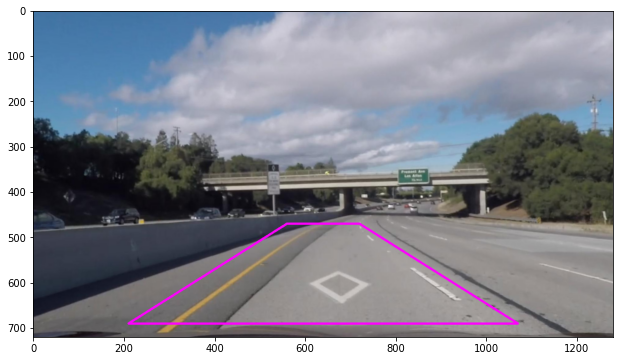

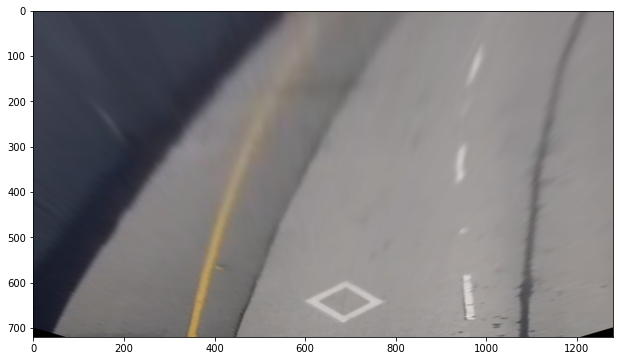

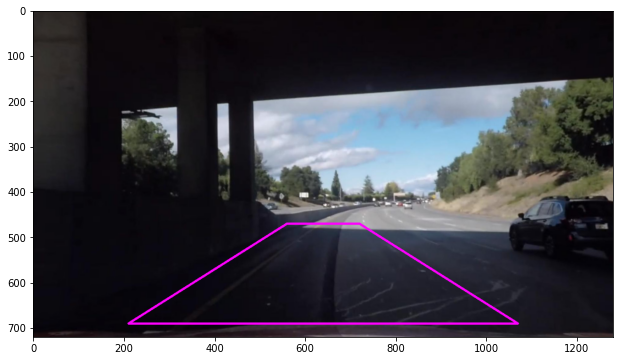

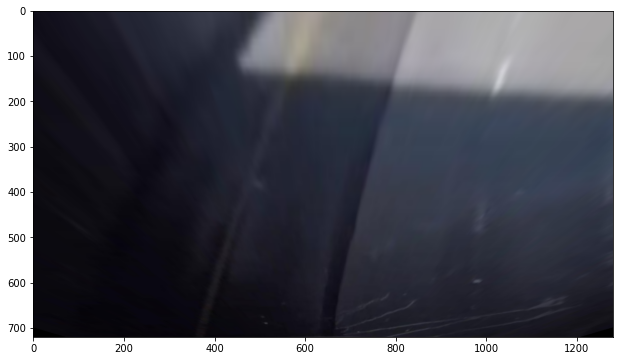

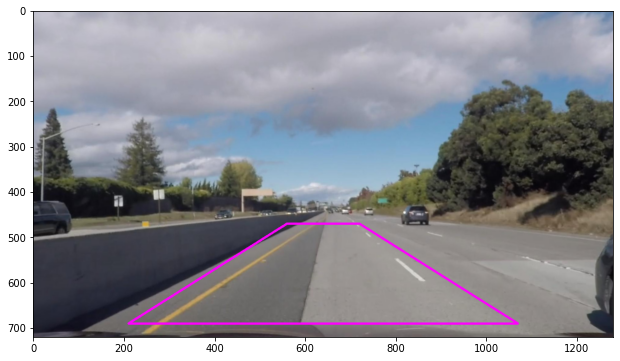

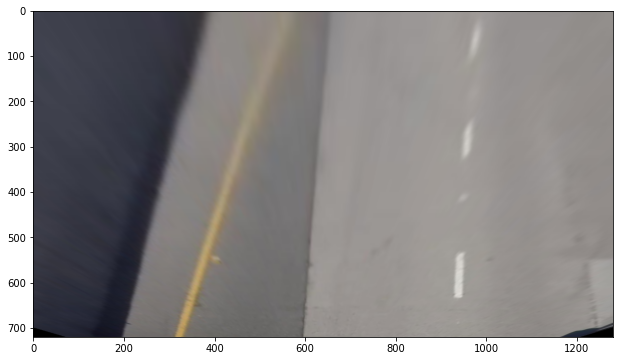

In [12]:
# Validate the warp transform
# https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html
for test_img in test_images[:1]:
    #break
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    
    fpv = undistorter.undistort(img)
    fpv_roi = plot_roi_on(fpv, CAMERA_ROI)
        
    plot_bgr(fpv_roi)
    
    birds_eye = bird.from_above(fpv)

    plot_bgr(birds_eye)

In [13]:
def adaptive_contrast(img, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lum = hls[:,:,1]
    sat = hls[:,:,2]
    
    top_significant = height//2 + height//10
    
    quarter_lum = lum[top_significant::4, ::4]
    quarter_sat = sat[top_significant::4, ::4]
    
    lum_hist = np.histogram(quarter_lum, 12)
    lum_thr = lum_hist[1][np.argmax(lum_hist[0])]
    
    sat_hist = np.histogram(quarter_sat, 8)
    sat_thr = sat_hist[1][np.argmax(sat_hist[0])]
    
    min_lum = np.maximum(0, quarter_lum.astype(np.int32) - lum_thr)
    lum_part = normalize(np.minimum(np.power(min_lum, 2), 2550))

    min_sat = np.maximum(0, quarter_sat.astype(np.int32) - sat_thr)
    sat_part = normalize(np.minimum(np.power(min_sat, 1.5), 600))
    
    mix = np.maximum(sat_part, lum_part)
    mix_hist = np.histogram(mix[::2, ::2],10)
    mix_thr = mix_hist[1][np.argmax(mix_hist[0])]
    mix = np.maximum(0, mix.astype(np.int32) - mix_thr)
    mix = normalize(np.power(mix, 2))
    
    limited_mix = np.maximum(0, np.minimum(mix, 255)).astype(np.uint8)
    output = np.zeros((height, width), dtype=np.uint8)
    output[top_significant:, :] = cv2.resize(limited_mix, (width, height - top_significant))
    return output



In [14]:
def subtract_major_tone(img, downsample=2, accuracy=10):
    hist = np.histogram(img[::downsample, ::downsample], accuracy)
    major = hist[1][np.argmax(hist[0])]
    if (major <= 1.0):
        second_max = np.partition(hist[0], -2)[-2]
        second_max_idx = np.where(hist[0] == second_max)
        major = hist[1][second_max_idx]

    return np.maximum(0, img.astype(np.int32) - major)

def adaptive_vertical_contrast(img, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    B = img[::2,::2,0]
    G = img[::2,::2,1]
    R = img[::2,::2,2]
    
    hue = hls[:,:,0]
    lum = hls[:,:,1]
    sat = hls[:,:,2]
    
    left_significant = int(width * 0.1)#height//2 + height//10
    right_significant = int(width * 0.9)
    
    quarter_hue = hue[::2, ::2]
    quarter_lum = lum[::2, ::2]
    quarter_sat = sat[::2, ::2]
    
    #plot_gray(B)#quarter_hue)
    #plot_gray(G)#quarter_lum)
    #plot_gray(R)#quarter_sat)
    
    yellow = np.uint8((R.astype(np.uint16) + G) // 2)
    filtered_yellow = subtract_major_tone(yellow)

    quarter_sat = np.uint8((quarter_sat.astype(np.uint16) + filtered_yellow) // 2)
    
    quarter_lum = yellow
    
    min_lum = subtract_major_tone(subtract_major_tone(quarter_lum))
    lum_part = normalize(np.minimum(np.power(min_lum, 2), 2550))

    min_sat = subtract_major_tone(subtract_major_tone(quarter_sat))
    sat_part = normalize(np.minimum(np.power(min_sat, 2), 2000))

    #plot_gray(sat_part)
    #plot_gray(lum_part)
    
    #mix = sat_part.astype(np.uint16) + lum_part
    mix = np.uint16(np.maximum(sat_part, lum_part))
    mix = normalize(np.power(mix, 2))
    #mix_shifted = subtract_major_tone(mix)
    
    limited_mix = np.maximum(0, np.minimum(mix, 255)).astype(np.uint8)
    output = cv2.resize(limited_mix, (width, height))
    return output

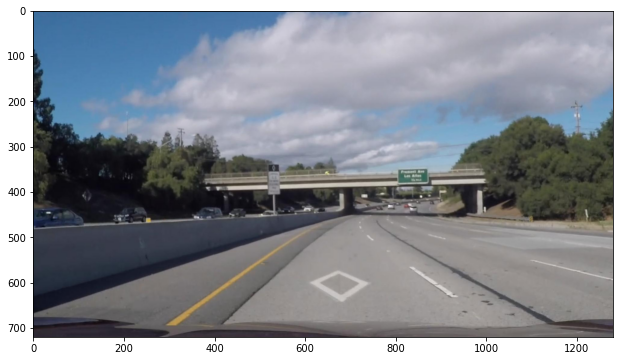

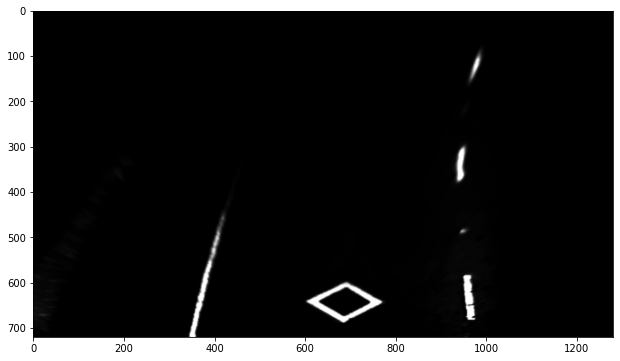

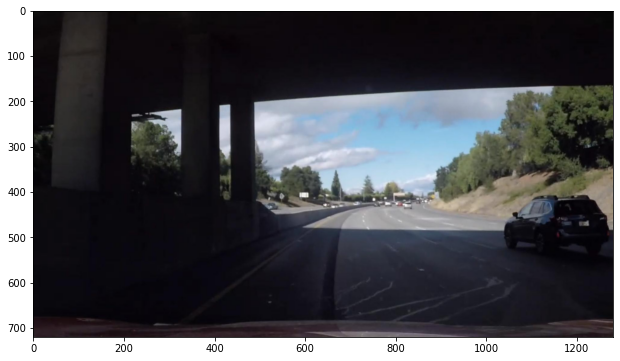

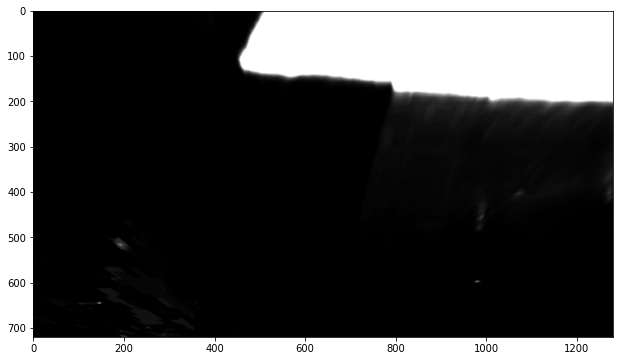

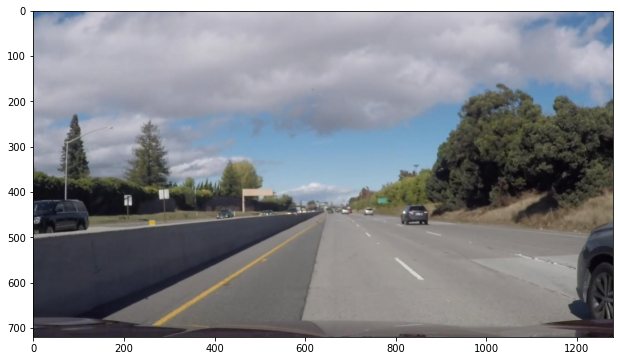

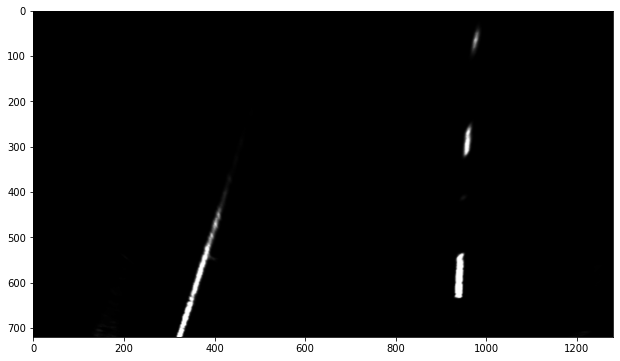

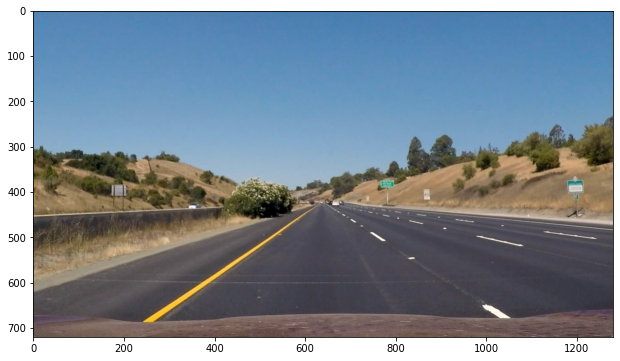

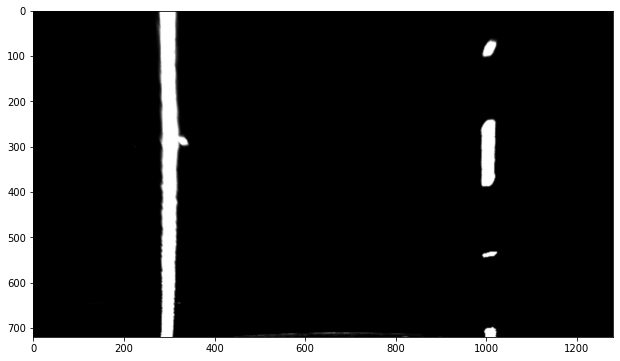

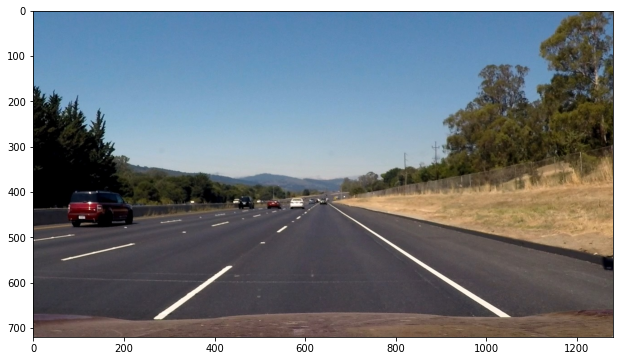

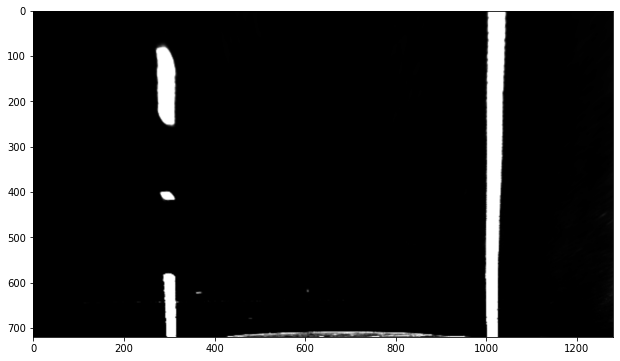

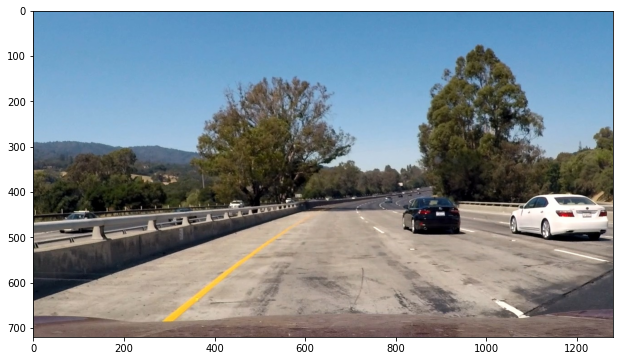

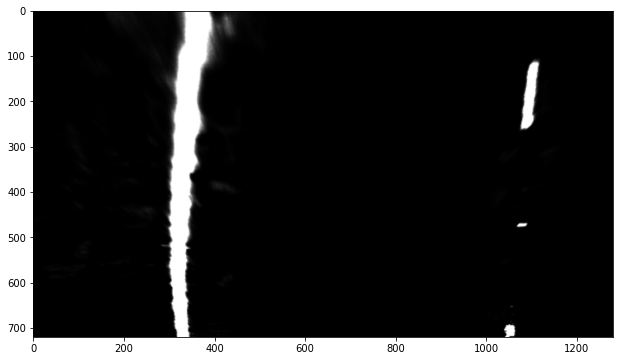

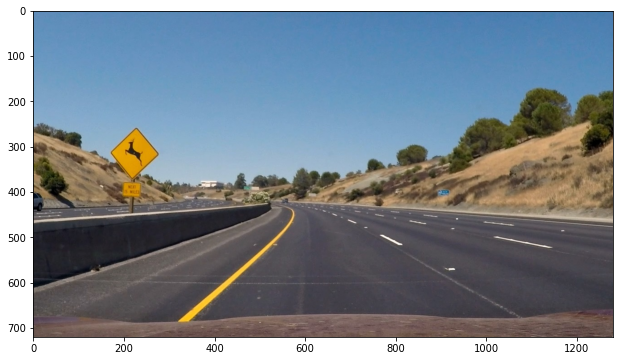

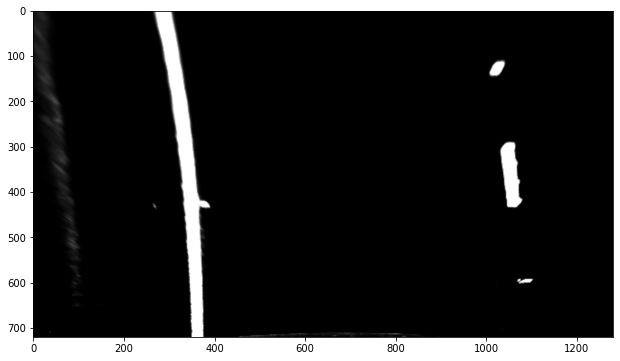

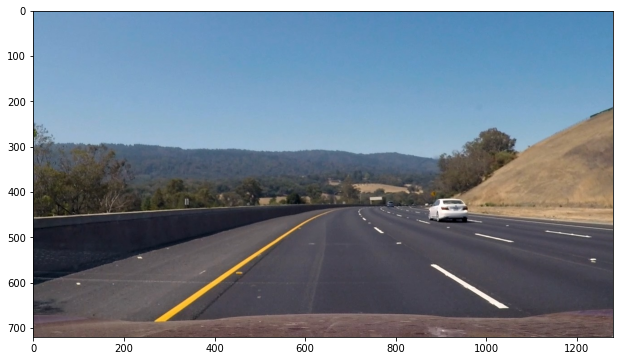

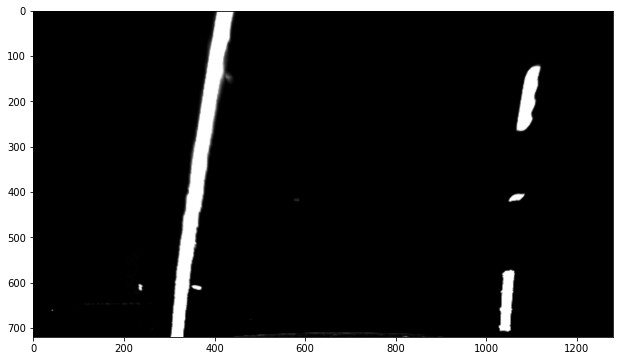

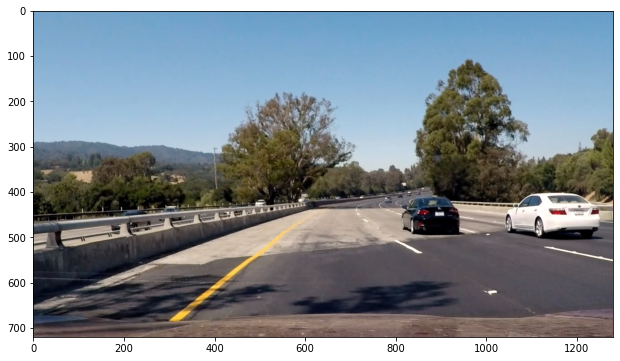

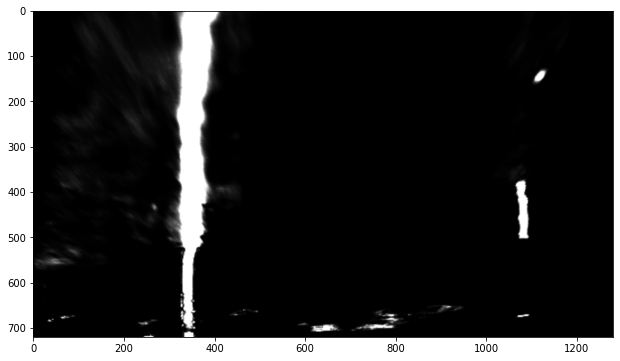

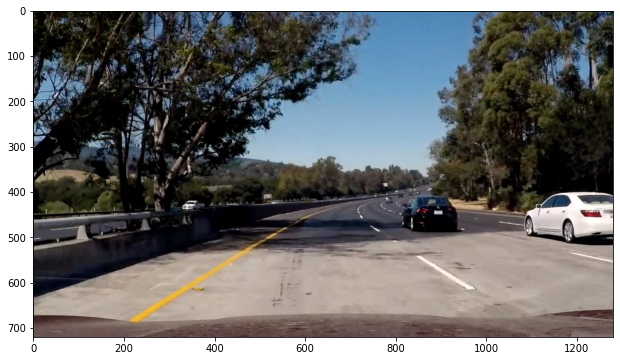

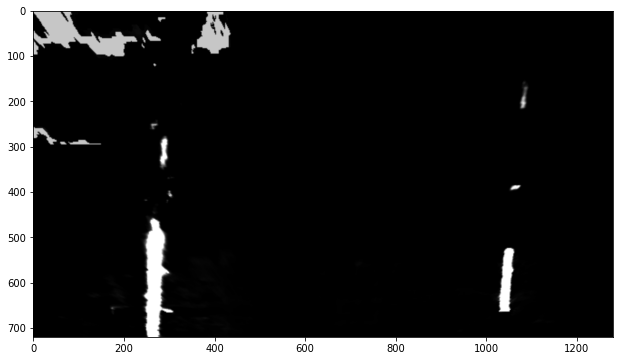

In [15]:
# Validate the HLS pipeline
for test_img in test_images[:1]:
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    temp = adaptive_vertical_contrast(bird.from_above(undistorter.undistort(img)))
    #_, st_1 = cv2.threshold(cv2.bitwise_and(temp, mask), 70,255,cv2.THRESH_BINARY)
    #st_1 = cv2.bitwise_and(temp, mask)
    
    plot_bgr(img)
    plot_gray(temp)

In [16]:
# Good: gray_input, blur_radius=5, sobel_kernel=17 angle_range=(0.7, 1.3), magnitude_range=(75,255)
# TRY; gray_input, blur_radius=3, sobel_kernel=11 angle_range=(0.85, 1.15), magnitude_range=(30,255)
ANGLE_RANGE=(0.6, 1.15)
def amplify_lane_pixels(gray_input, blur_radius=3, sobel_kernel=15
                        , angle_range=ANGLE_RANGE, magnitude_range=(30,255), save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    # Either medianBlur or GaussianBlur
    # blurred = cv2.medianBlur(gray_input, blur_radius)
    blurred = cv2.GaussianBlur(gray_input, (blur_radius, blur_radius), 0)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range
    direction = np.zeros_like(angles)
    direction[(angles >= angle_min) & (angles <= angle_max)] = 1
    # plot_gray(direction)
    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;
    magnitude = np.zeros_like(blurred)
    magnitude[(mag_raw > min_magnitude) & (mag_raw < max_magnitude)] = 1
    # plot_gray(magnitude)
    # Combining thresholds
    combined = np.zeros_like(blurred)
    combined[((magnitude == 1) & (direction == 1))] = 1
    #combined = magnitude + direction
    # plot_gray(combined)
    dilate_kernel = np.ones((3,3),np.uint8)
    erode_kernel = np.ones((3,3),np.uint8)
    #output = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, dilate_kernel)
    output = combined
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

    
    

In [17]:
def amplify_lane_pixels2(gray_input, blur_radius=5, sobel_kernel=17
                        , angle_range=(0.7, 1.2), magnitude_range=(20,255), save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    # Either medianBlur or GaussianBlur
    #blurred = cv2.medianBlur(gray_input, blur_radius)
    blurred = cv2.GaussianBlur(gray_input, (blur_radius, blur_radius), 0)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range
    #direction = np.zeros_like(angles)
    #direction[(angles >= angle_min) & (angles <= angle_max)] = 1
    # plot_gray(direction)
    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;

    # Combining thresholds
    combined = np.zeros_like(blurred)
    combined[(((mag_raw > min_magnitude) & (mag_raw < max_magnitude))\
              & ((angles >= angle_min) & (angles <= angle_max)))] = 255
    output = combined
    #dilate_kernel = np.ones((3,3),np.uint8)
    #output = cv2.morphologyEx(combined, cv2.MORPH_OPEN, dilate_kernel)
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

In [18]:
def amplify_vert_lane_pixels(gray_input, blur_radius=5, sobel_kernel=7
                        , angle_range=(0, 0.5), magnitude_range=(50,255), save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    # Either medianBlur or GaussianBlur
    #blurred = cv2.medianBlur(gray_input, blur_radius)
    blurred = gray_input[::4, ::4] # cv2.GaussianBlur(gray_input, (blur_radius, blur_radius), 0)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range
    #direction = np.zeros_like(angles)
    #direction[(angles >= angle_min) & (angles <= angle_max)] = 1
    # plot_gray(direction)
    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;

    # Combining thresholds
    combined = np.zeros_like(blurred)
    combined[(((mag_raw > min_magnitude) & (mag_raw < max_magnitude))\
              & ((angles >= angle_min) & (angles <= angle_max)))] = 255
    output = cv2.resize(combined, (gray_input.shape[1], gray_input.shape[0]))
    #dilate_kernel = np.ones((3,3),np.uint8)
    #output = cv2.morphologyEx(combined, cv2.MORPH_OPEN, dilate_kernel)
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

In [19]:
def contrast_processing(img):
    bird_eye = bird.from_above(undistorter.undistort(img))
    contrast = adaptive_vertical_contrast(bird_eye)
    #_, st_1 = cv2.threshold(contrast, 15, 255, cv2.THRESH_BINARY)
    st_1 = contrast
    st_2 = normalize(amplify_vert_lane_pixels(st_1, angle_range=(-0.5, 0.5),
                                              magnitude_range=(20,255),
                                             sobel_kernel=3))
    return cv2.cvtColor(st_2, cv2.COLOR_GRAY2RGB)

In [20]:
#input_video = 'harder_challenge_video.mp4'; test_video_output = 'test_video_output/contrast_harder_challenge_test_video.mp4'
input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/contrast_challenge_test_video.mp4'
#input_video = 'project_video.mp4'; test_video_output = 'test_video_output/contrast_test_video.mp4'

# 37-43 subclip of the main one is the worst
clip1 = VideoFileClip(input_video).subclip(5,8)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(contrast_processing)
%time white_clip.write_videofile(test_video_output, audio=False)

t:   3%|▎         | 3/90 [00:00<00:05, 16.50it/s, now=None]

Moviepy - Building video test_video_output/contrast_challenge_test_video.mp4.
Moviepy - Writing video test_video_output/contrast_challenge_test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/contrast_challenge_test_video.mp4
CPU times: user 22.1 s, sys: 2.3 s, total: 24.4 s
Wall time: 7.41 s


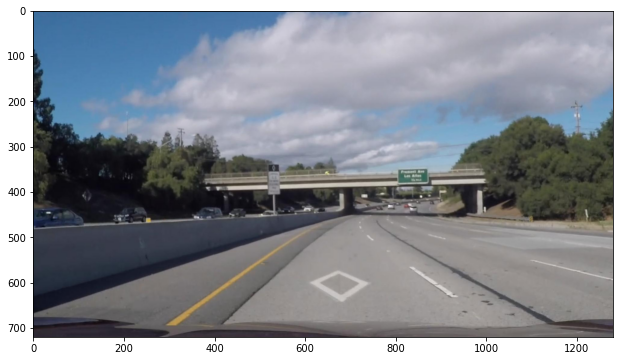

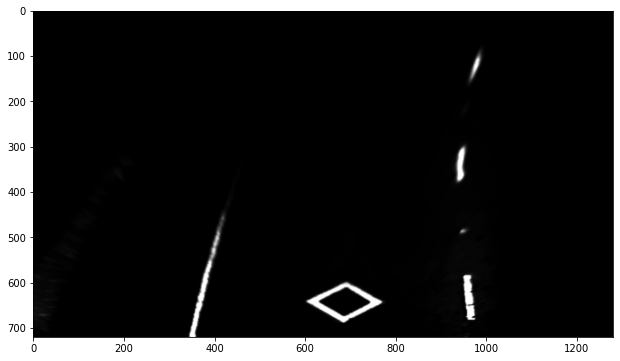

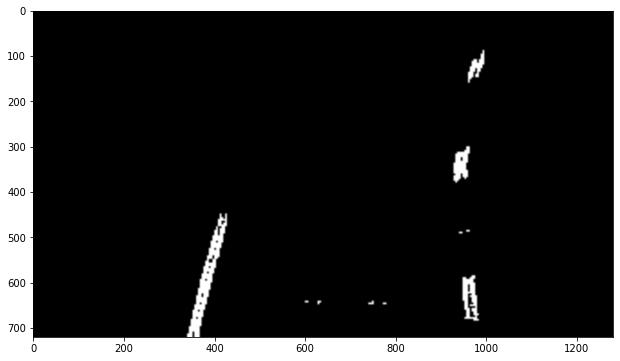

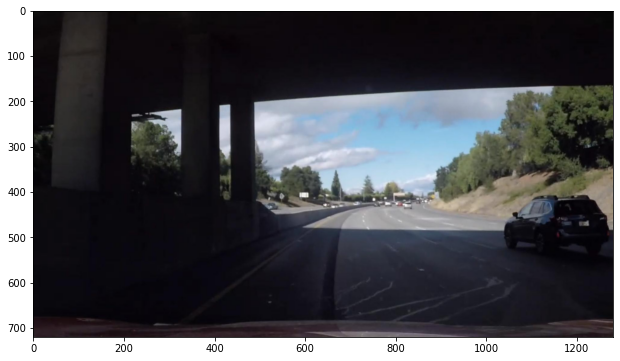

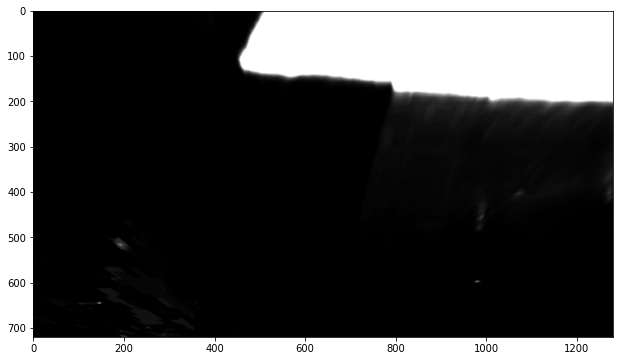

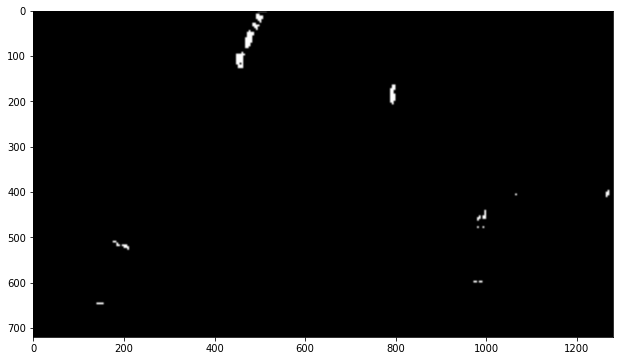

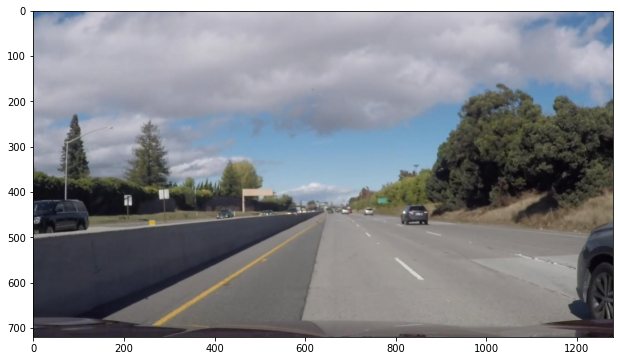

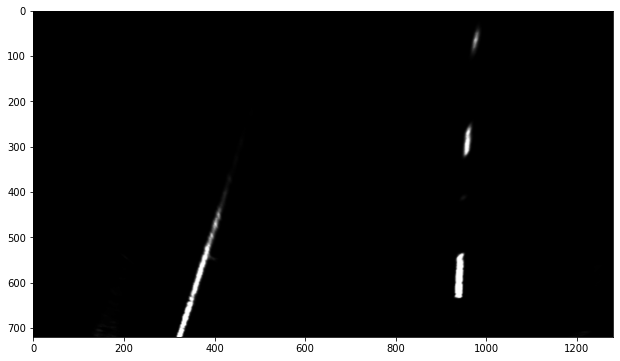

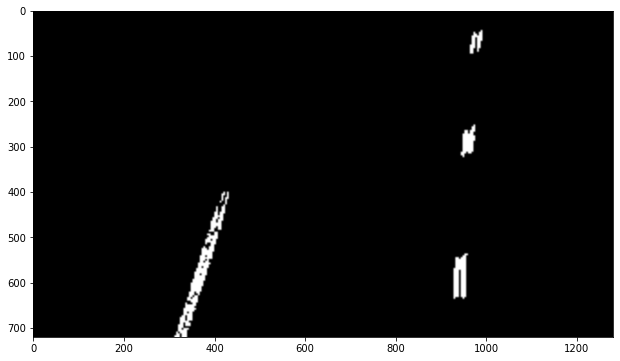

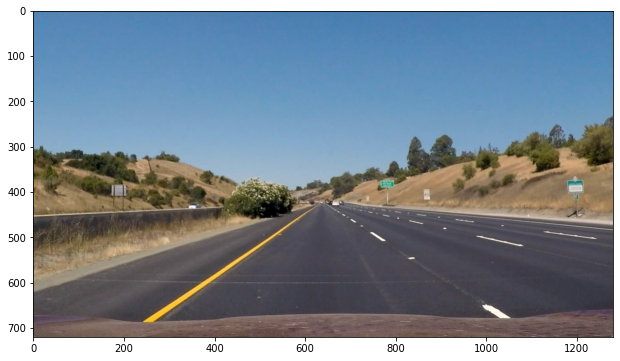

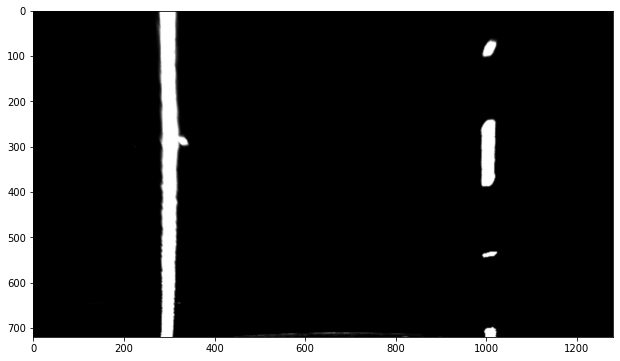

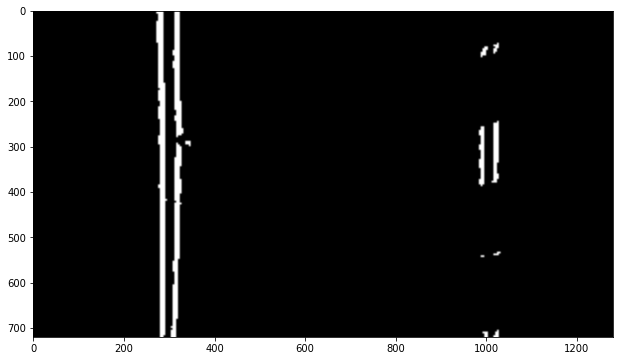

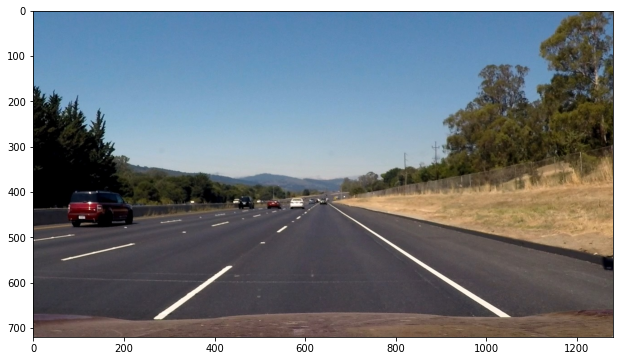

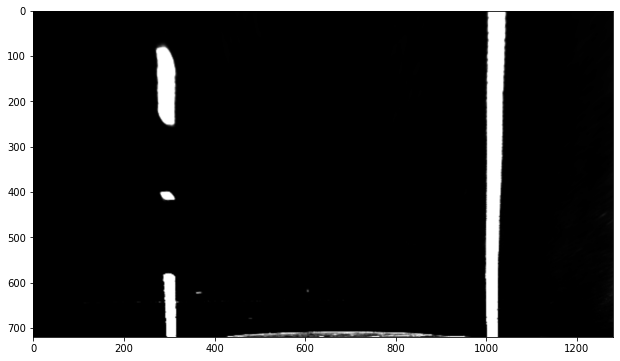

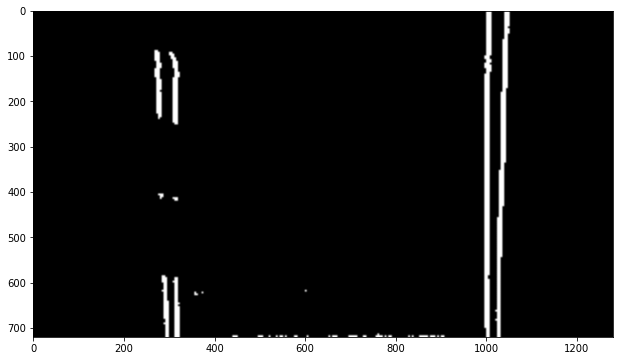

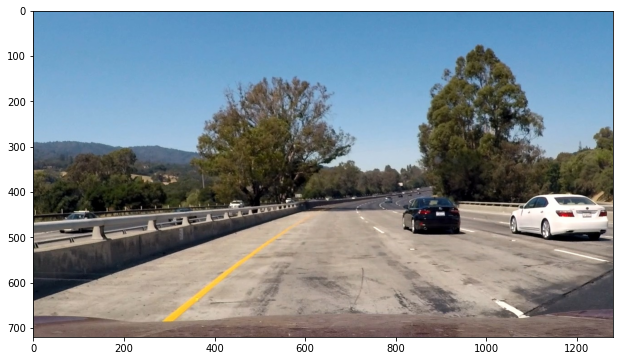

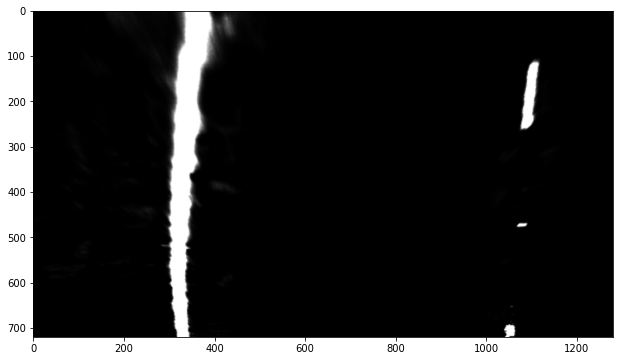

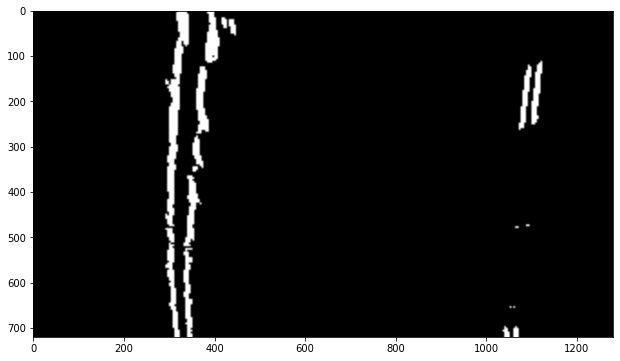

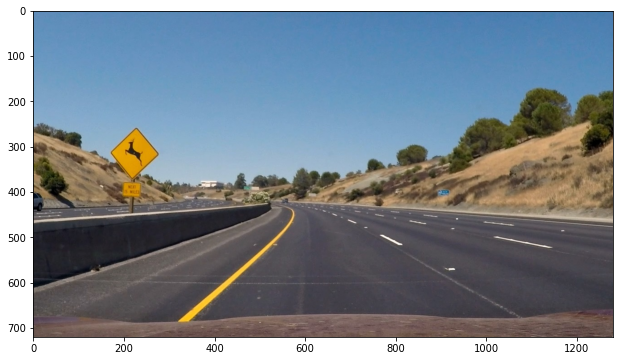

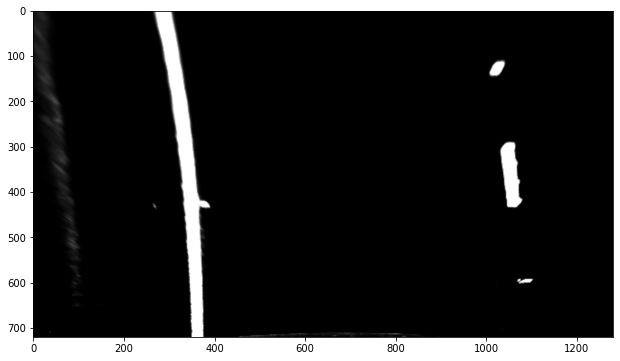

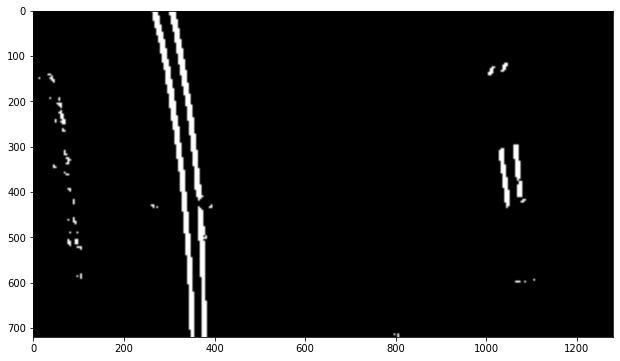

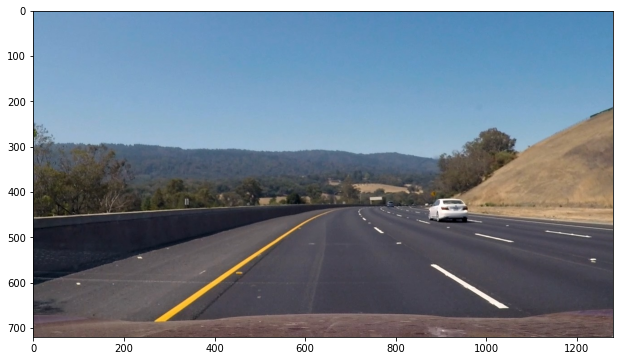

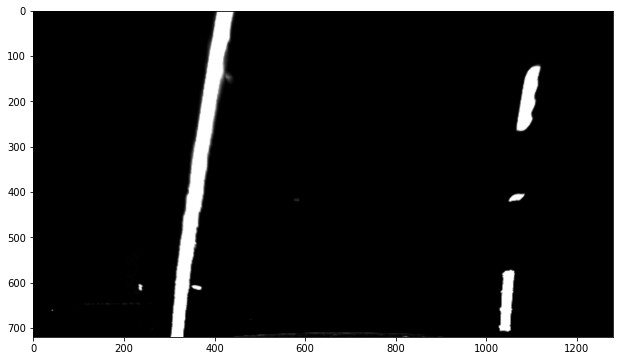

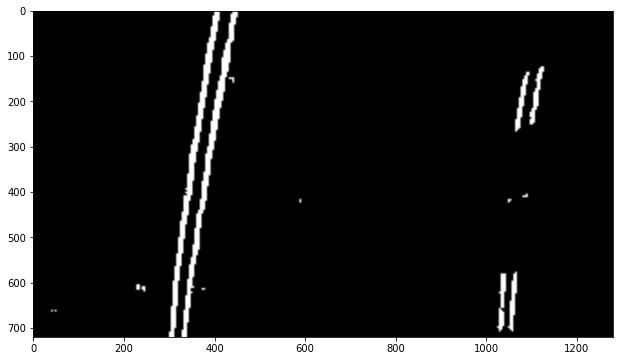

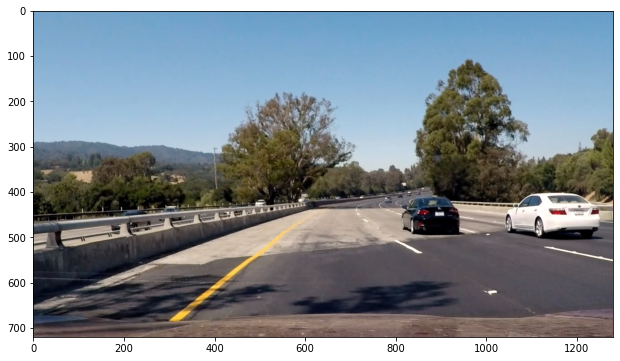

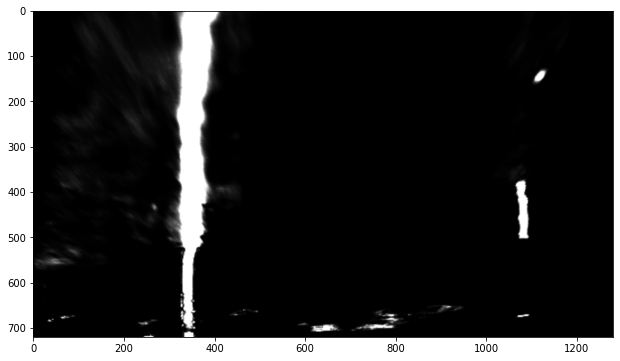

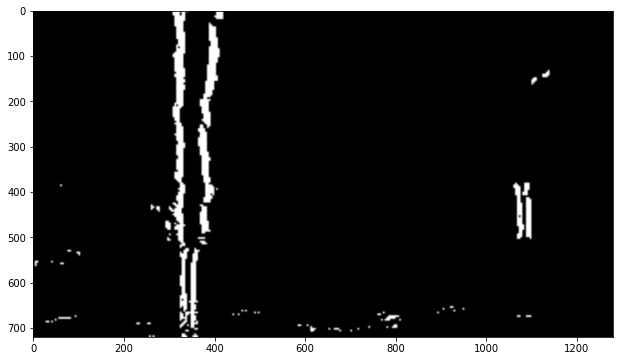

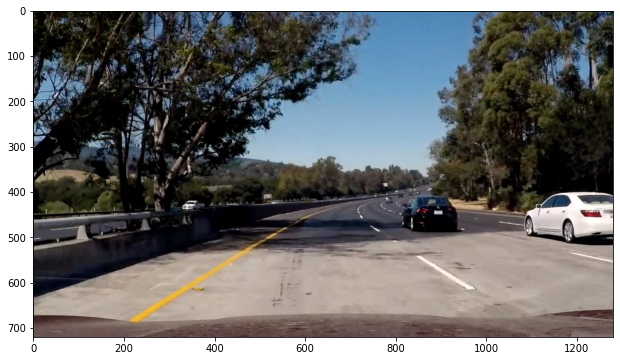

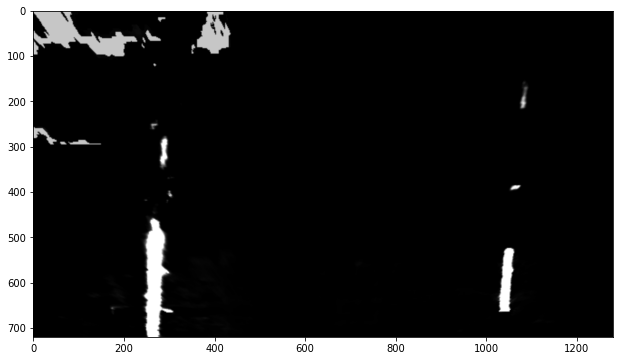

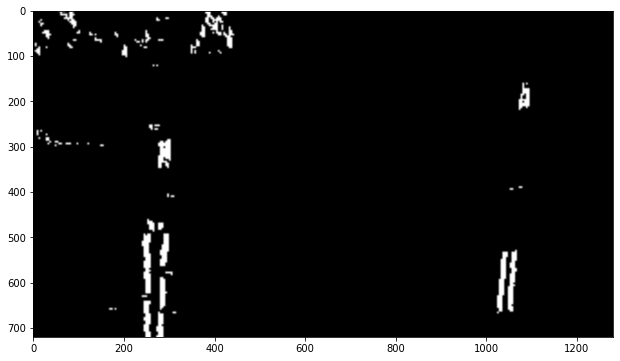

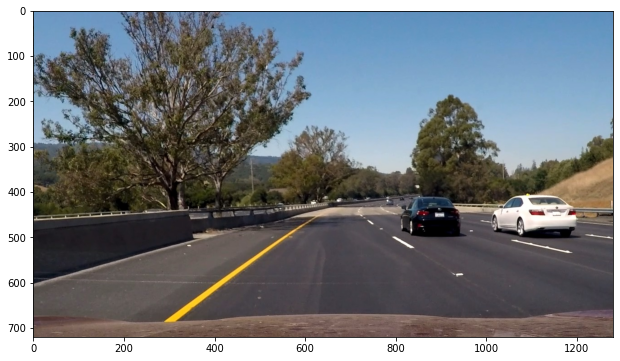

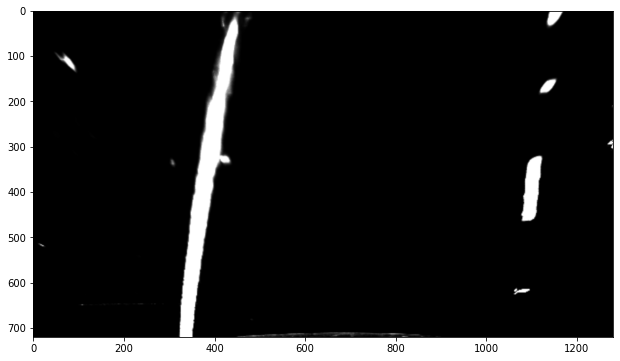

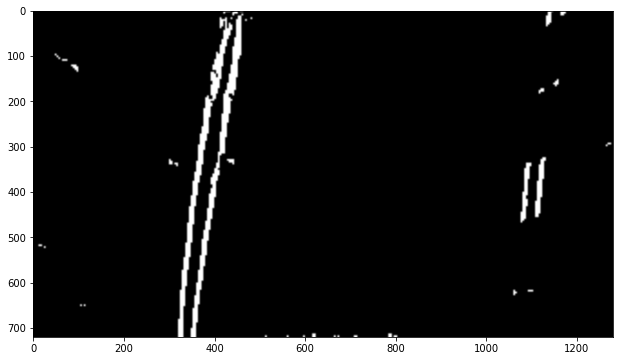

In [21]:
# Validate the HLS pipeline
for test_img in test_images[:1]:
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    bird_eye = bird.from_above(undistorter.undistort(img))
    contrast = adaptive_vertical_contrast(bird_eye)
    #_, st_1 = cv2.threshold(contrast, 15, 255, cv2.THRESH_BINARY)
    st_1 = contrast
    st_2 = normalize(amplify_vert_lane_pixels(st_1, angle_range=(-0.5, 0.5),
                                              magnitude_range=(20,255),
                                             sobel_kernel=3))
    plot_bgr(img)
    plot_gray(contrast)
    #plot_gray(st_1)
    plot_gray(st_2)

In [22]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [36]:
def evaluate_poly2(poly, y):
    ''' Evaluate a 2-grade polynomial '''
    return poly[0]*y*y + poly[1]*y + poly[2]

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, xm_per_pix, ym_per_pix):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    if (len(leftx) == 0 or len(lefty) == 0):
        left_fit = np.float32([1.0,1.0,1.0])
    else:
        left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        
    if (len(rightx == 0) or len(righty) == 0):
        right_fit = np.float32([1.0,1.0,1.0])
    else:
        right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return left_fit, right_fit

def get_plottable_curves(height, left_fit, right_fit, xm_per_pix, ym_per_pix, steps=20):
    ploty = np.linspace(0, height, steps)
    left_curve = np.int32(list(zip(
        evaluate_poly2(left_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    right_curve = np.int32(list(zip(
        evaluate_poly2(right_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    return left_curve, right_curve
    
def plot_lane_curves(lane_img, left_curve, right_curve, thickness=6):
    out_img = cv2.polylines(lane_img, [left_curve], False, [0,255,255], thickness)
    out_img = cv2.polylines(out_img, [right_curve], False, [255,255,0], thickness)
    return out_img

def plot_lane_poly_on(lane_img, left_curve, right_curve, color=[100,200,100]):
    # Right curve's points must go in the opposite order to maintain a
    # polygon's points traversing order.
    points = np.append(left_curve, right_curve[::-1], axis=0)
    cv2.fillPoly(lane_img, [points], color)

In [37]:
class LaneLine():
    def __init__(self, xm_per_pix, ym_per_pix, img_size=(1280, 720), avg_depth=8):
        self.avg_depth = avg_depth
        # Poly coefficients. averaged during last N calls
        self.avg_fit = None
        self.isValid = False
        # Lane curvature radius in meters
        self.radius_m = 1e3
        # Distance in meters of vehicle center from the line
        # (assuming the car is centered and the lane width is 3.75 meters)
        self.line_base_pos_mm = 3750./2
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix
        self.img_width, self.img_height = img_size
        self.lane_h_center_mm = (self.img_width // 2) * self.xm_per_pix * 1000.
    
    def update(self, poly, x_pixels=None, y_pixels=None):
        if x_pixels is not None:
            self.x_pixels = x_pixels
        if y_pixels is not None:
            self.y_pixels = y_pixels
        if self.avg_fit is None:
            self.avg_fit = poly
        else:
            # Improvement of a naive averaging: if the diff is huge,
            # do a more conservative averaging. 
            # TODO: probably, not every member is equally important.
            diff = np.absolute(self.avg_fit - poly)
            weighted_diff = (diff[0]**2) + np.absolute(diff[1])
            #weighted_diff = np.absolute(diff[0]) + np.absolute(diff[1]) + np.absolute(diff[2])
            dynamic_depth = int(max(weighted_diff, self.avg_depth))
            self.avg_fit = (self.avg_fit * (dynamic_depth - 1) + poly) / dynamic_depth
        self.line_base_pos_mm = evaluate_poly2(
            self.avg_fit, self.img_height * self.ym_per_pix)*1000 - self.lane_h_center_mm
        
    def get_fit(self):
        return self.avg_fit
    
    @staticmethod
    def evaluate_poly2(poly, y):
        # Evaluates a 2-grade polynomial
        return poly[0]*y*y + poly[1]*y + poly[2]
    
    @staticmethod
    def curvature(polynome, ycoord):
        if polynome is None:
            return 0.
        A, B, C = polynome
        numerator = np.power((1 + np.power((2 * A * ycoord + B), 2)), 3/2)
        denominator = 2 * np.abs(A)
        return numerator / denominator
    
    def get_curvature(self):
        new_curvature = self.curvature(self.avg_fit, self.img_height * ym_per_pix)
        self.radius_m = (self.radius_m * (self.avg_depth - 1) + new_curvature) / self.avg_depth
        return self.radius_m
    
    def get_horizontal_offset(self):
        return self.line_base_pos_mm
    
    def reset(self):
        self.avg_fit = None
        self.isValid = False
        self.radius_m = 1e3
        self.line_base_pos_mm = 3750./2
        self.allx = None  
        self.ally = None

In [38]:
def plot_circles(img, lcurv, rcurv):
    avg_curv = (lcurv + rcurv) / 2
    r_color = [0,0,255]
    l_color = [255,0,255]
    thickness = 15
    height, width = img.shape[:2]
    h_center = width // 2
    left_avg_center = (int(h_center - avg_curv), height)
    right_avg_center = (int(h_center + avg_curv), height)
    #img, center, radius, color[, thickness
    cv2.circle(img, left_avg_center, int(avg_curv), l_color, thickness)
    cv2.circle(img, right_avg_center, int(avg_curv), r_color, thickness)
    
def plot_curvatures_on(img, lcurvature, rcurvature, color=(255, 255, 255), fontScale = 0.6, thickness = 1):
    height, width = img.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    origin = (int(width * 0.05), int(height * 0.1)) 

    # Using cv2.putText() method 
    return cv2.putText(img, 
                        "Radius: left {:5.1f} m, right {:5.1f} m, avg lane {:5.1f} m"
                        .format(lcurvature, rcurvature, (lcurvature + rcurvature) / 2), 
                        origin, font,  
                       fontScale, color, thickness, cv2.LINE_AA)

def plot_hcenter_offset_on(img, loffset, roffset, thickness = 1):
    offset = loffset + roffset
    height, width = img.shape[:2]
    green = (0, 255, 0)
    red = (0, 0, 255)
    origin = (int(width * 0.55), int(height * 0.9)) if (offset > 0) else (int(width * 0.35), int(height * 0.9)) 
    color = green if (offset > 0) else red
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 0.6; thickness = 1
    return cv2.putText(img, 
                        "Offset {} mm" .format(int(offset)), 
                        origin, font,  
                       fontScale, color, thickness, cv2.LINE_AA)
    

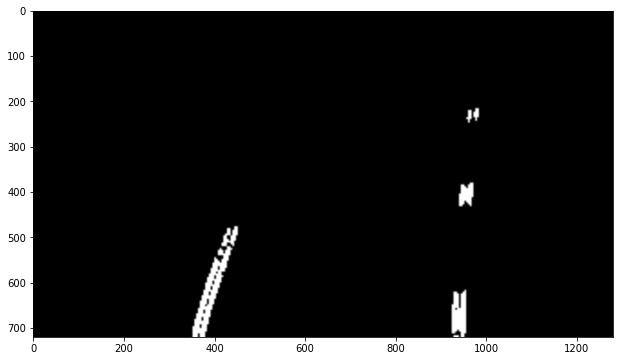

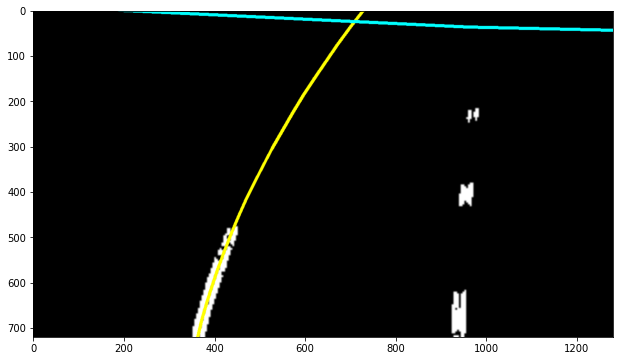

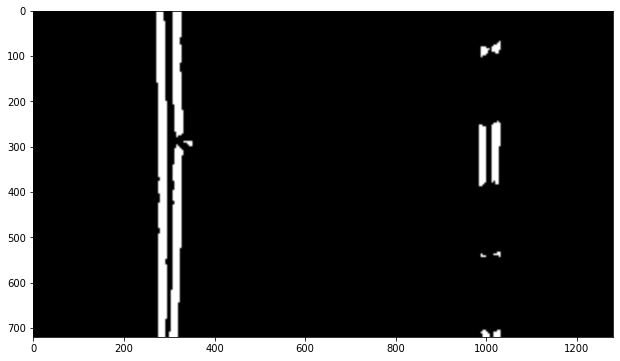

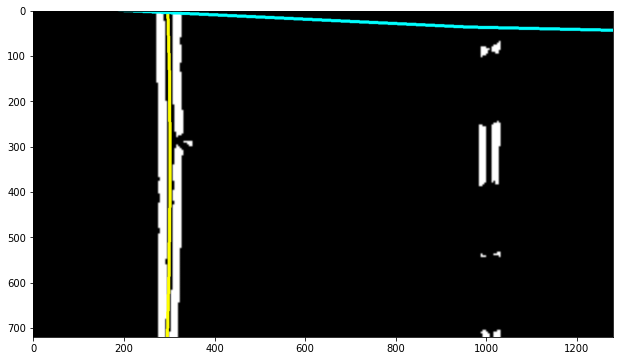

In [39]:
# Validate lane pixel finding via sliding window
for test_img in test_images[2:4]:
    img = cv2.resize(undistorter.undistort(cv2.imread(test_img)), (1280, 720))
    #plot_bgr(plot_roi_on(img, CAMERA_ROI))
    hls = adaptive_vertical_contrast(bird.from_above(img))
    highlight = amplify_vert_lane_pixels(hls, mask)
    birds_eye = highlight
    lfit, rfit = fit_polynomial(birds_eye, xm_per_pix, ym_per_pix)
    lcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)
    found = plot_lane_curves(cv2.cvtColor(birds_eye, cv2.COLOR_GRAY2BGR), lcurve, rcurve)
    lcurv = LaneLine.curvature(lfit, 720 * ym_per_pix)
    rcurv = LaneLine.curvature(rfit, 720 * ym_per_pix)
   
    plot_gray(highlight)
    
    #plot_circles(found, lcurv, rcurv)
    #plot_lane_poly_on(found, lcurve, rcurve)    
    plot_bgr(found)
    

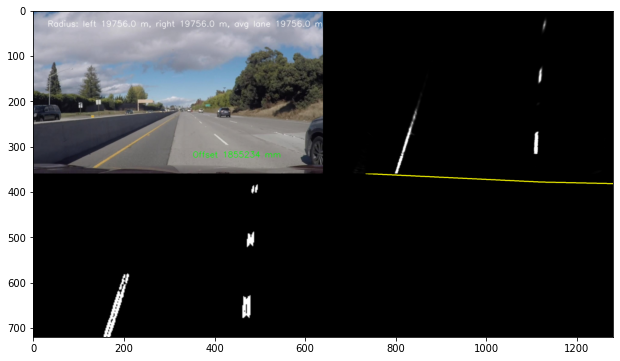

In [29]:
# Note: an Undistorter instance is necessary
# xm_per_pix, ym_per_pix, img_size=(1280, 720), avg_depth=8
rlane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=6)
llane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=6)

buffer_frame = np.zeros((720, 1280), dtype=np.uint8)
buffer_frame[::10, ::10] = 255 # salting the buffer to start.
buf_avg = 10

def process_frame(frame):
    global buffer_frame, buf_avg
    """ Expects an RGB frame as input """
    height, width, _ = frame.shape
    birds_eye = bird.from_above(undistorter.undistort(frame))
    stage_0_sample = adaptive_vertical_contrast(birds_eye)
    stage_1_sample = normalize(amplify_vert_lane_pixels(stage_0_sample))
    #_, stage_1_sample = cv2.threshold(cv2.bitwise_and(stage_0_sample, mask), 40,255,cv2.THRESH_BINARY)
    stage_2_sample = stage_1_sample#bird.from_above(stage_1_sample)
    
    buffer_frame = (buffer_frame * (buf_avg - 1) + stage_2_sample) / buf_avg
    filtered_stage2 = np.zeros_like(stage_2_sample)
    filtered_stage2[buffer_frame > 40] = 1 # was 40!
    filtered_stage2 = cv2.morphologyEx(filtered_stage2, cv2.MORPH_OPEN, np.ones((7,7)))
    
    lfit, rfit = fit_polynomial(filtered_stage2, #stage_2_sample,
                                xm_per_pix, ym_per_pix)
    llane.update(lfit); rlane.update(rfit);
    
    lcurve, rcurve = get_plottable_curves(height, llane.get_fit(), rlane.get_fit()
                                          , xm_per_pix, ym_per_pix)
    
    stage_3_sample = plot_lane_curves(cv2.cvtColor(normalize(filtered_stage2), #stage_2_sample,
                                                   cv2.COLOR_GRAY2BGR)
                                      , lcurve, rcurve)
    #plot_circles(stage_3_sample, llane.get_curvature()/xm_per_pix, rlane.get_curvature()/xm_per_pix)
    
    tile_01 = cv2.cvtColor(cv2.resize(stage_0_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_10 = cv2.cvtColor(cv2.resize(stage_1_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_11 = cv2.resize(stage_3_sample, (width//2, height//2))
        
    road_poly_from_above = np.zeros_like(frame)
    plot_lane_poly_on(road_poly_from_above, lcurve, rcurve)
    #plot_circles(road_poly_from_above, llane.get_curvature(), rlane.get_curvature())
    lane_poly = bird.to_road(road_poly_from_above)
    tile_00 = cv2.resize(np.maximum(frame, lane_poly), (width//2, height//2))
    
    plot_curvatures_on(tile_00, llane.get_curvature(), rlane.get_curvature())

    plot_hcenter_offset_on(tile_00, llane.get_horizontal_offset(), rlane.get_horizontal_offset())
    
    output = np.zeros_like(frame)
    output [:height//2, :width//2] = tile_00
    output [:height//2, width//2:] = tile_01
    output [height//2:, :width//2] = tile_10
    output [height//2:, width//2:] = tile_11
    return output

# Validate lane pixel finding via sliding window
for test_img in test_images[2:3]:
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    plot_bgr(process_frame(img))

In [31]:
#input_video = 'harder_challenge_video.mp4'; test_video_output = 'test_video_output/harder_challenge_test_video.mp4'
#input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/challenge_test_video.mp4'
input_video = 'project_video.mp4'; test_video_output = 'test_video_output/test_video.mp4'

# 37-43 subclip of the main one is the worst
clip1 = VideoFileClip(input_video).subclip(1,6)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(test_video_output, audio=False)

t:   2%|▏         | 2/125 [00:00<00:08, 14.43it/s, now=None]

Moviepy - Building video test_video_output/test_video.mp4.
Moviepy - Writing video test_video_output/test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/test_video.mp4
CPU times: user 41.3 s, sys: 4.76 s, total: 46.1 s
Wall time: 16.5 s
